# Nunique article_id per month
## Background 
- map@12 は、買われる確率が高い順に予測されることが期待される
  - よく買われる > たまに買われる > 買われない　のようになっているということ
- 現状2値で扱っているため、よく買われる=たまに買われる として扱われている
- 一方で、公開notebookではアクティブなアイテムに絞るとスコアが改善されている
  - ほかの可能性としては、自分のモデルの実装がおかしい（主にtransfomer）
  - アクティブの定義については

In [1]:
import os
import glob
import pathlib

from tqdm.notebook import tqdm
import datetime

import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-darkgrid")

from PIL import Image

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 50)

## Load Raw Data

In [2]:
%%time

data_dir = "../data/raw/"

data = pd.read_csv(data_dir + "transactions_train.csv", dtype={'article_id':str})
articles = pd.read_csv(data_dir + "articles.csv")
customers = pd.read_csv(data_dir + "customers.csv")

CPU times: user 23.3 s, sys: 4.6 s, total: 27.9 s
Wall time: 27.9 s


## Transaction Data

### transactions_train.csv

In [3]:
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31788324 entries, 0 to 31788323
Data columns (total 5 columns):
 #   Column            Dtype  
---  ------            -----  
 0   t_dat             object 
 1   customer_id       object 
 2   article_id        object 
 3   price             float64
 4   sales_channel_id  int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 1.2+ GB
None


,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687004,0.016932,2


最終Submissionに使われるデータは、`transactions_train.csv`で観測される`t_dat`の最新日から翌7日間が使われる。

まずは、その最新日を確かめる。ついでに最も古い日も出す。

In [4]:
print("最新日 : ", data["t_dat"].max())
print("最も古い日 : ", data["t_dat"].min())

最新日 :  2020-09-22
最も古い日 :  2018-09-20


Submission に使われる期間は、2020-09-23 ~ 2020-09-29

In [5]:
c_rows = data["customer_id"]

In [6]:
# 一度に買うアイテム数の傾向
# モデルのseaquence_sizeの参考にする

c_cnt_each_article_cnt = c_rows.value_counts().value_counts().sort_index()
c_cumsum_each_article_cnt = c_cnt_each_article_cnt.cumsum() / c_cnt_each_article_cnt.sum()

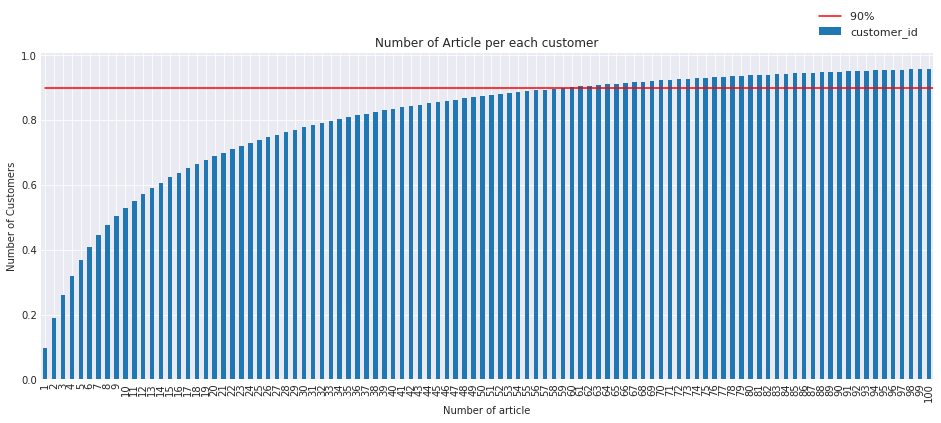

In [7]:
c_cumsum_each_article_cnt[:100].plot(
    title="Number of Article per each customer",
    kind="bar",
    figsize=(16, 6),
)
plt.plot([0, 100], [0.9, 0.9],color="red", label="90% ")
plt.legend(bbox_to_anchor=(1, 1), loc="lower right", borderaxespad=1, fontsize=11)
plt.xlabel("Number of article")
plt.ylabel("Number of Customers")
plt.show()

In [8]:
data["t_dat"] = pd.to_datetime(data["t_dat"], format="%Y-%m-%d")

In [9]:
data["YM"] = data["t_dat"].dt.year.astype(str) + "-" + data["t_dat"].dt.month.astype(str).str.zfill(2)

In [10]:
raw_result = data.groupby("YM")["article_id"].agg("nunique").sort_index()

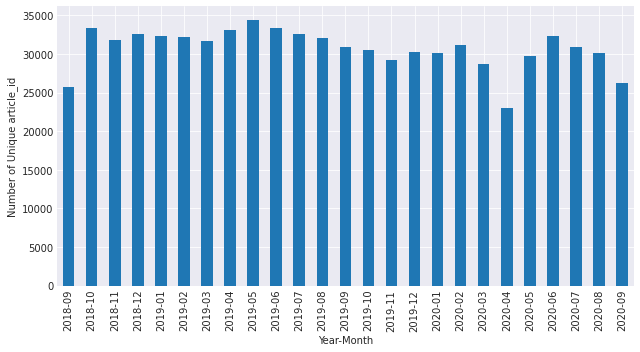

In [11]:
raw_result.plot(kind="bar", figsize=(9,5))
plt.xlabel("Year-Month")
plt.ylabel("Number of Unique article_id")
plt.tight_layout()
plt.show()

Active Ratio: 0.6876977885581096


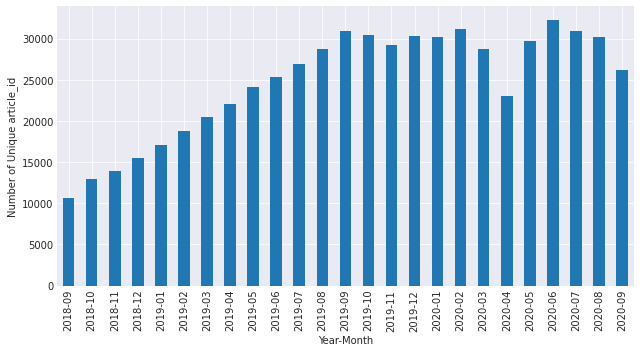

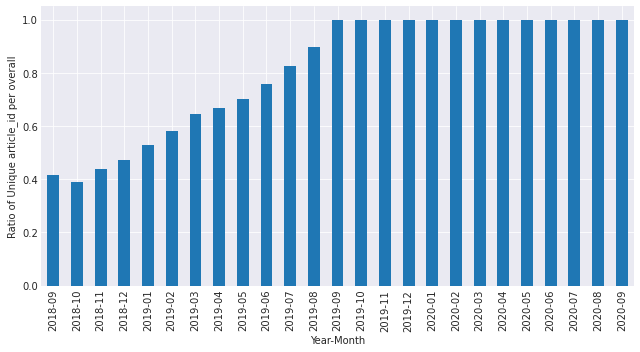

In [12]:
active_articles = data.groupby("article_id")["t_dat"].max().reset_index()
active_articles = active_articles[active_articles["t_dat"] >= "2019-09-01"].reset_index()
print("Active Ratio:", active_articles.shape[0] / 105542)

active_data = data[data["article_id"].isin(active_articles["article_id"])].copy()
result = active_data.groupby("YM")["article_id"].agg("nunique")

result.plot(kind="bar", figsize=(9,5))
plt.xlabel("Year-Month")
plt.ylabel("Number of Unique article_id")
plt.tight_layout()
plt.show()

(result / raw_result).plot(kind="bar", figsize=(9,5))
plt.xlabel("Year-Month")
plt.ylabel("Ratio of Unique article_id per overall")
plt.tight_layout()
plt.show()

Active Ratio: 0.4813249701540619


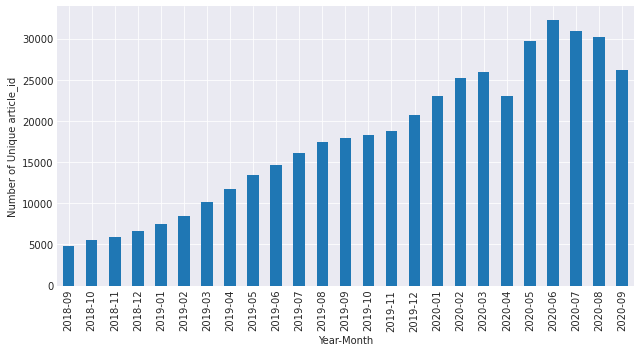

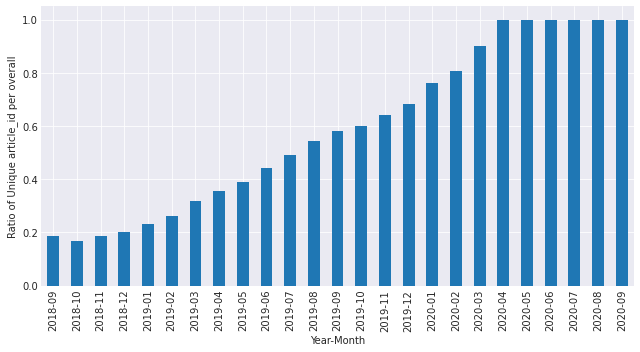

In [13]:
active_articles = data.groupby("article_id")["t_dat"].max().reset_index()
active_articles = active_articles[active_articles["t_dat"] >= "2020-04-01"].reset_index()
print("Active Ratio:", active_articles.shape[0] / 105542)

active_data = data[data["article_id"].isin(active_articles["article_id"])].copy()
result = active_data.groupby("YM")["article_id"].agg("nunique")

result.plot(kind="bar", figsize=(9,5))
plt.xlabel("Year-Month")
plt.ylabel("Number of Unique article_id")
plt.tight_layout()
plt.show()

(result / raw_result).plot(kind="bar", figsize=(9,5))
plt.xlabel("Year-Month")
plt.ylabel("Ratio of Unique article_id per overall")
plt.tight_layout()
plt.show()

Active Ratio: 0.2487351007181975


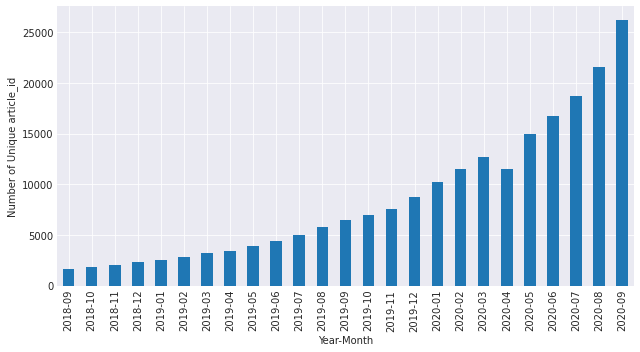

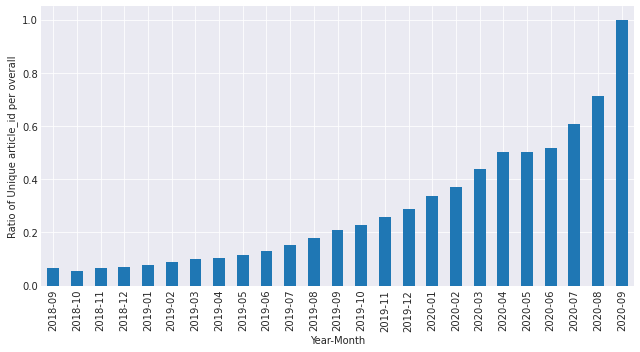

In [14]:
active_articles = data.groupby("article_id")["t_dat"].max().reset_index()
active_articles = active_articles[active_articles["t_dat"] >= "2020-09-01"].reset_index()
print("Active Ratio:", active_articles.shape[0] / 105542)

active_data = data[data["article_id"].isin(active_articles["article_id"])].copy()
result = active_data.groupby("YM")["article_id"].agg("nunique")

result.plot(kind="bar", figsize=(9,5))
plt.xlabel("Year-Month")
plt.ylabel("Number of Unique article_id")
plt.tight_layout()
plt.show()

(result / raw_result).plot(kind="bar", figsize=(9,5))
plt.xlabel("Year-Month")
plt.ylabel("Ratio of Unique article_id per overall")
plt.tight_layout()
plt.show()

- 全体の数については思ったより減らなかった
  - なので、この条件で削っても学習は問題ないように感じる
  - もっと削ってもいいかも？
- 削った後は案の定アップトレンドになった
  - 単純に当てやすくなっている可能性がある
- 過去の商品で現在買えないものは予測する必要がないので削ってもいいようにおもう
- 一方でシーズンものや似ている新作などの長い期間での周期性などを学習しにくくなるので、これらの特徴については外装する必要がありそう
  - 例えば、この人は毎年赤色のワンピースを好んで買っていてワンピースに合う小物も合わせて買う、など。
  - 最低限のシーズンものを考慮するために1年前までをアクティブなアイテムにしてる？